In [1]:
import cv2
import os
import re
import matplotlib.pyplot as plt
import ants
# import cucim

In [4]:
img_dir = '/storage/valis_reg/BFIW_original/'
imgs = os.listdir(img_dir)
regex = re.compile(r".*-SE_(\d+)_original.jpg")
imgs = sorted(imgs, key=lambda x: int(regex.match(x).group(1)))
imgs_ordered = {}
for img in imgs:
    section_num = int(regex.match(img).group(1))
    section_id = str(section_num)
    section_id_digits = len(section_id)
    if section_id_digits <4:
        section_id = '0'*(4-section_id_digits) + str(section_num)
    imgs_ordered[section_id] = os.path.join(img_dir, img)

In [2]:
import numpy as np
import cv2

def get_ksize(sigma):
    # opencv calculates ksize from sigma as
    # sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8
    # then ksize from sigma is
    # ksize = ((sigma - 0.8)/0.15) + 2.0

    return int(((sigma - 0.8)/0.15) + 2.0)

def get_gaussian_blur(img, ksize=0, sigma=5):
    # if ksize == 0, then compute ksize from sigma
    if ksize == 0:
        ksize = get_ksize(sigma)

    # Gaussian 2D-kernel can be seperable into 2-orthogonal vectors
    # then compute full kernel by taking outer product or simply mul(V, V.T)
    sep_k = cv2.getGaussianKernel(ksize, sigma)

    # if ksize >= 11, then convolution is computed by applying fourier transform
    return cv2.filter2D(img, -1, np.outer(sep_k, sep_k))

def ssr(img, sigma):
    # Single-scale retinex of an image
    # SSR(x, y) = log(I(x, y)) - log(I(x, y)*F(x, y))
    # F = surrounding function, here Gaussian

    return np.log10(img) - np.log10(get_gaussian_blur(img, ksize=0, sigma=sigma) + 1.0)

def msr(img, sigma_scales=[15, 80, 250]):
    # Multi-scale retinex of an image
    # MSR(x,y) = sum(weight[i]*SSR(x,y, scale[i])), i = {1..n} scales

    msr = np.zeros(img.shape)
    # for each sigma scale compute SSR
    for sigma in sigma_scales:
        msr += ssr(img, sigma)

    # divide MSR by weights of each scale
    # here we use equal weights
    msr = msr / len(sigma_scales)

    # computed MSR could be in range [-k, +l], k and l could be any real value
    # so normalize the MSR image values in range [0, 255]
    msr = cv2.normalize(msr, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)

    return msr

def color_balance(img, low_per, high_per):
    '''Contrast stretch img by histogram equilization with black and white cap'''

    tot_pix = img.shape[1] * img.shape[0]
    # no.of pixels to black-out and white-out
    low_count = tot_pix * low_per / 100
    high_count = tot_pix * (100 - high_per) / 100

    # channels of image
    ch_list = []
    if len(img.shape) == 2:
        ch_list = [img]
    else:
        ch_list = cv2.split(img)

    cs_img = []
    # for each channel, apply contrast-stretch
    for i in range(len(ch_list)):
        ch = ch_list[i]
        # cummulative histogram sum of channel
        cum_hist_sum = np.cumsum(cv2.calcHist([ch], [0], None, [256], (0, 256)))

        # find indices for blacking and whiting out pixels
        li, hi = np.searchsorted(cum_hist_sum, (low_count, high_count))
        if (li == hi):
            cs_img.append(ch)
            continue
        # lut with min-max normalization for [0-255] bins
        lut = np.array([0 if i < li
                        else (255 if i > hi else round((i - li) / (hi - li) * 255))
                        for i in np.arange(0, 256)], dtype = 'uint8')
        # constrast-stretch channel
        cs_ch = cv2.LUT(ch, lut)
        cs_img.append(cs_ch)

    if len(cs_img) == 1:
        return np.squeeze(cs_img)
    elif len(cs_img) > 1:
        return cv2.merge(cs_img)
    return None

def msrcr(img, sigma_scales=[15, 80, 250], alpha=125, beta=46, G=192, b=-30, low_per=1, high_per=3):
    # Multi-scale retinex with Color Restoration
    # MSRCR(x,y) = G * [MSR(x,y)*CRF(x,y) - b], G=gain and b=offset
    # CRF(x,y) = beta*[log(alpha*I(x,y) - log(I'(x,y))]
    # I'(x,y) = sum(Ic(x,y)), c={0...k-1}, k=no.of channels

    img = img.astype(np.float64) + 1.0
    # Multi-scale retinex and don't normalize the output
    msr_img = msr(img, sigma_scales)
    # Color-restoration function
    crf = beta * (np.log10(alpha * img) - np.log10(np.sum(img, axis=2, keepdims=True)))
    # MSRCR
    msrcr_ = G * (msr_img*crf - b)
    # normalize MSRCR
    msrcr_ = cv2.normalize(msrcr_, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8UC3) # type: ignore
    # color balance the final MSRCR to flat the histogram distribution with tails on both sides
    msrcr_ = color_balance(msrcr_, low_per, high_per)

    return msrcr_

(-0.5, 1547.5, 1535.5, -0.5)

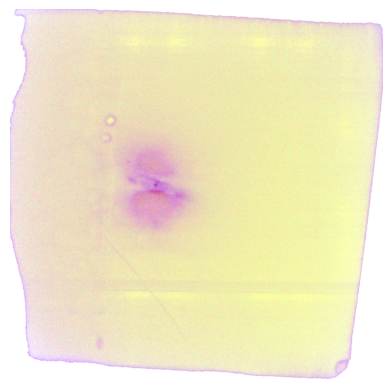

In [137]:
# ssr_img = ssr(np.min(img, -1), 5)
import numpy as np
import scipy
import skimage
img_path = img_dir + imgs[0]
# img_path = '/storage/valis_reg/cropped_imgs/1806.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ssr_img = msrcr(img.copy())
ssr_img_gray = cv2.cvtColor(ssr_img.copy(), cv2.COLOR_RGB2GRAY)  # type: ignore
# img = np.min(img.clip(100,150),0)
# return img
# sample_img = read_image_gray(img_dir + imgs[1606])
sample_ants = ants.from_numpy(ssr_img_gray)
sample_mask = sample_ants.get_mask(cleanup=4) # type: ignore
mask = sample_mask.numpy().astype(np.uint8)
blank_white = (np.ones_like(ssr_img) * 255).astype(np.uint8)
# for i in range(3):
#     blank_white[mask==1] = img[mask==1]
for i in range(3):
    blank_white[:,:,i][mask==1] = ssr_img[:,:,i][mask==1] # type: ignore
# plt.imshow(blank_white)
# jet 
# plt.imshow(cv2.cvtColor(blank_white, cv2.COLOR_RGB2GRAY), cmap='jet')
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
# find the bounding box of the largest contour
x, y, w, h = cv2.boundingRect(contours[0])
# draw the bounding box
# blnk_rect = cv2.rectangle(blank_white, (x, y), (x+w, y+h), (0, 255, 0), 2)
rect_blank = blank_white.copy()[y:y+h, x:x+w]
rect_mask = mask.copy()[y:y+h, x:x+w]
# blank_rect = np.ones_like(rect_mask) * 255
plt.imshow(rect_blank[:,:,1])
alpha = 1.1
xy = (
    (rect_blank[:, :, 2] < alpha*skimage.filters.threshold_otsu(rect_blank[:, :, 2])).astype(
        np.uint8
    )
    + (
        rect_blank[:, :, 1] < alpha*skimage.filters.threshold_otsu(rect_blank[:, :, 1])
    ).astype(np.uint8)
    + (
        rect_blank[:, :, 0] < alpha*skimage.filters.threshold_otsu(rect_blank[:, :, 0])
    ).astype(np.uint8)
)
blurred_xy = cv2.GaussianBlur((xy==3).astype(np.uint8).copy(), (13, 13), 0)
blurred_xy = cv2.GaussianBlur(blurred_xy.copy(), (9, 9), 0)
blurred_xy = cv2.medianBlur(blurred_xy, 9)
# dilate the mask
blurred_xy = cv2.dilate(blurred_xy, (9,9), iterations=10) # type: ignore
# Rectangle Crop
contours,_ = cv2.findContours(blurred_xy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)
bbox = cv2.boundingRect(contours[0])
x, y, w, h = bbox
rect_blank = rect_blank[int(0.9*y):y+h+int(y*0.1), int(0.9*x):x+w+int(x*0.1)]
plt.imshow(rect_blank)
plt.axis('off')


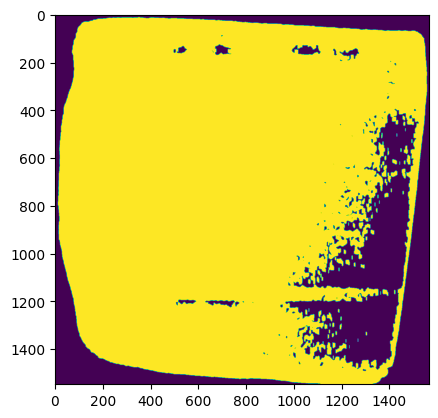

In [138]:
plt.imshow(blurred_xy)

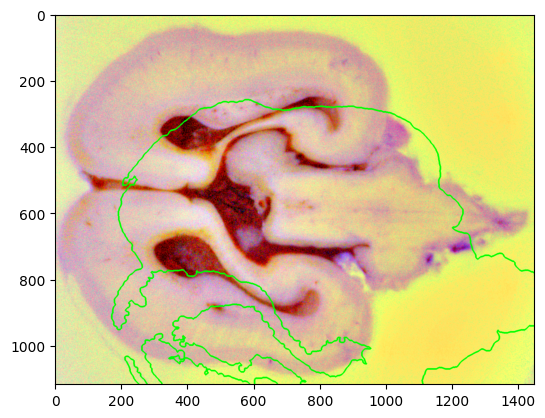

In [128]:

# Draw the contour
plt.imshow(cv2.drawContours(rect_blank.copy(), contours, 0, (0, 255, 0), 3))

In [59]:
skimage.filters.threshold_otsu(rect_blank[:,:,2])

201

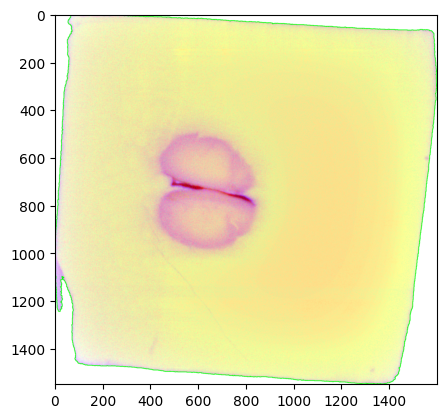

In [70]:
contours, _ = cv2.findContours(xy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)

# plot the largest contour
# plt.imshow(cv2.drawContours(rect_blank.copy(), contours, -1, (0, 255, 0), 2))


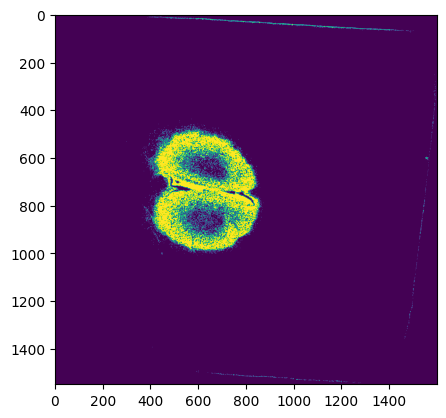